# Import dependencies and determine working directory

In [1]:
# Import libraries
import numpy as np
from os import path
import cv2
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
# get current directory
dir = path.dirname(path.abspath('__file__'))

# Define functions to process images

## Create classifiers

In [3]:
# load cascade classifiers https://github.com/opencv/opencv/tree/master/data/haarcascades
def load_classifiers(): 
    face_cascade_path = path.join(dir,'..','02_pretrained_models', 'haarcascade_frontalface_default.xml')
    left_eye_cascade_path = path.join(dir,'..','02_pretrained_models', 'haarcascade_lefteye_2splits.xml')
    right_eye_cascade_path = path.join(dir,'..','02_pretrained_models', 'haarcascade_righteye_2splits.xml')

    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    left_eye_cascade = cv2.CascadeClassifier(left_eye_cascade_path)
    right_eye_cascade = cv2.CascadeClassifier(right_eye_cascade_path)
    
    return face_cascade, left_eye_cascade, right_eye_cascade

## Create colour conversion functions

In [4]:
# Convert image to colour
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert image to greyscale
def convertToGray(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Identify head

In [5]:
def identify_head(imagePath, face_cascade):
    # Read the image
    image = cv2.imread(imagePath)

    # Convert to gray
    gray = convertToGray(image)
    
    # detect face
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor= 1.1,
        minNeighbors=5,
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    
    # draw a rectangle around the face
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # show image 
    plt.imshow(convertToRGB(image))
    plt.show()
    
    # extract the face 
    (x, y, w, h) = faces[0]
    head = image[y:y + h, x:x + w]
    
    return head

## Center face, adjust tilt and resize image

In [6]:
def process_face(head, left_eye_cascade, right_eye_cascade):
    # define search areas 
    head_height, head_width = head.shape[:2]
    top_eye_edge = math.floor(0.1*head_height)
    bottom_eye_edge = math.floor(0.6*head_height)
    left_eye_edge = math.floor(0.1*head_width)
    center_edge = math.floor(0.5*head_width)
    right_eye_edge = math.floor(0.9*head_width)
    left_eye_area = head[top_eye_edge:bottom_eye_edge, left_eye_edge:center_edge]
    right_eye_area = head[top_eye_edge:bottom_eye_edge, center_edge:right_eye_edge]
    
    # define fixed parameters for scaling 
    desired_left_eye = (0.3, 0.3)
    desired_face_width = 128
    desired_face_height = desired_face_width
    
    # Instantiate variables
    left_eye_middle = None
    right_eye_middle = None
    
    # Locate eyes
    left_eye = left_eye_cascade.detectMultiScale(left_eye_area, scaleFactor=1.1, minNeighbors=2)
    right_eye = right_eye_cascade.detectMultiScale(right_eye_area, scaleFactor=1.1, minNeighbors=2)
    
    # Find the middle of the left and right eyes
    if left_eye is () or right_eye is ():
        return  cv2.resize(head, (desired_face_width, desired_face_height)) 
    else: 
        for (x_left, y_left, w_left, h_left) in left_eye:
            left_eye_middle = np.array([ left_eye_edge + x_left + w_left / 2, top_eye_edge + y_left + h_left / 2])

        for (x_right, y_right, w_right, h_right) in right_eye:
            right_eye_middle = np.array([center_edge + x_right + w_right / 2, top_eye_edge + y_right + h_right / 2])
        
        # draw eye regions
        cv2.rectangle(head, (left_eye_edge + x_left, top_eye_edge + y_left), (left_eye_edge + x_left +w_left, top_eye_edge + y_left+h_left), (255, 0, 0), 2)
        cv2.rectangle(head, (center_edge +x_right, top_eye_edge + y_right), (center_edge +x_right+w_right, top_eye_edge + y_right+h_right), (255, 0, 0), 2)
        
        # show image 
        plt.imshow(convertToRGB(head))
        plt.show()
        
        # draw middle of eyes and line connecting the two
        cv2.circle(head, (int(left_eye_middle[0]),  int(left_eye_middle[1]) ), 2, (0, 0, 255), 4)
        cv2.circle(head, (int(right_eye_middle[0]),  int(right_eye_middle[1]) ), 2, (0, 0, 255), 4)
        cv2.line(head, (int(left_eye_middle[0]),  int(left_eye_middle[1]) ),(int(right_eye_middle[0]),  int(right_eye_middle[1]) ), (0, 0, 255), 2)

        # show image 
        plt.imshow(convertToRGB(head))
        plt.show()
            
        # Find the middle point between the eyes
        eye_middle = (left_eye_middle + right_eye_middle) / 2
        
        # draw middle eye line
        cv2.circle(head, (int(eye_middle[0]),  int(eye_middle[1]) ), 2, (0, 255, 0), 4)
        
        # show image 
        plt.imshow(convertToRGB(head))
        plt.show()

        # Find the angle of the eye line 
        eye_angle_rad = np.arctan2(right_eye_middle[1] - left_eye_middle[1], right_eye_middle[0] - left_eye_middle[0]) 
        eye_angle_deg = eye_angle_rad * 180.0 / math.pi
        
        # Find the scaling factor
        face_scale_factor = (1.0 - desired_left_eye[0] * 2) * desired_face_width / np.linalg.norm(right_eye_middle - left_eye_middle)
        
        # Set up rotation and scaling matrix 
        transformation_mat = cv2.getRotationMatrix2D(tuple(eye_middle), eye_angle_deg, face_scale_factor)

        # Center matrix around the center of the eyes
        transformation_mat[0,2] += desired_face_width * 0.5 - eye_middle[0]
        transformation_mat[1,2] += desired_left_eye[1] * desired_face_height - eye_middle[1]
        
        # Adjust image
        adjusted_face = cv2.warpAffine(head, transformation_mat, (desired_face_width, desired_face_height))
        
        return adjusted_face

In [7]:
def process_image(inputPath, outputPath):
    face_cascade, left_eye_cascade, right_eye_cascade = load_classifiers()
    head = identify_head(inputPath, face_cascade)
    adjusted_face = process_face(head, left_eye_cascade, right_eye_cascade)
    cv2.imwrite(outputPath, convertToGray(adjusted_face) )
    plt.imshow(convertToRGB(adjusted_face), cmap='gray')
    plt.show()
    plt.imshow(convertToGray(adjusted_face), cmap='gray')
    plt.show()

# Run function to process image

In [8]:
# get image path
# image_path = path.join(dir,'..','01_raw_data', 'CelebA', 'Img', 'img_celeba.7z', 'img_celeba', '000140.jpg')
# image_path = path.join(dir,'..','01_raw_data', 'jaffe', 'KA.AN1.39.tiff')
# image_path = path.join(dir,'..','01_raw_data', 'Portraits', 'image_12.png')
image_path = path.join(dir,'..','05_demo_image', 'sample1.jpg')

output_path = path.join(dir,'..','03_processed_images', 'sample', 'image_01.jpg')

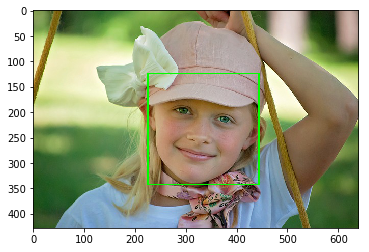

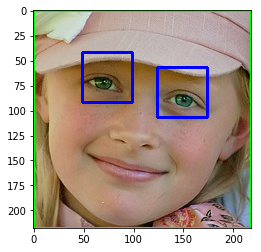

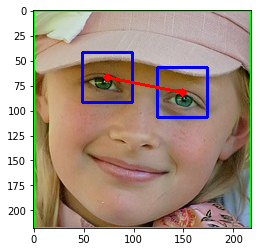

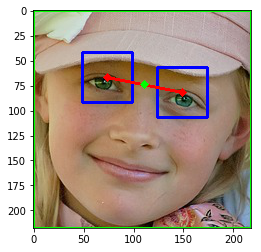

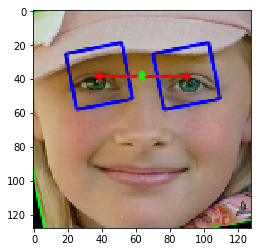

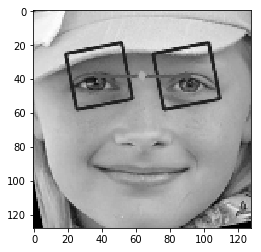

In [9]:
process_image(image_path, output_path)

# Redefine functions without steps for illustration

In [10]:
def identify_head(imagePath, face_cascade):
    # Read the image
    image = cv2.imread(imagePath)

    # Convert to gray
    gray = convertToGray(image)
    
    # detect face
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor= 1.1,
        minNeighbors=5,
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    
    # extract the face 
    (x, y, w, h) = faces[0]
    head = image[y:y + h, x:x + w]
    
    return head

In [7]:
def process_image(inputPath, outputPath):
    face_cascade, left_eye_cascade, right_eye_cascade = load_classifiers()
    head = identify_head(inputPath, face_cascade)
    adjusted_face = process_face(head, left_eye_cascade, right_eye_cascade)
    cv2.imwrite(outputPath, convertToGray(adjusted_face) )

In [11]:
def process_face(head, left_eye_cascade, right_eye_cascade):
    # define search areas 
    head_height, head_width = head.shape[:2]
    top_eye_edge = math.floor(0.1*head_height)
    bottom_eye_edge = math.floor(0.6*head_height)
    left_eye_edge = math.floor(0.1*head_width)
    center_edge = math.floor(0.5*head_width)
    right_eye_edge = math.floor(0.9*head_width)
    left_eye_area = head[top_eye_edge:bottom_eye_edge, left_eye_edge:center_edge]
    right_eye_area = head[top_eye_edge:bottom_eye_edge, center_edge:right_eye_edge]
    
    # define fixed parameters for scaling 
    desired_left_eye = (0.3, 0.3)
    desired_face_width = 128
    desired_face_height = desired_face_width
    
    # Instantiate variables
    left_eye_middle = None
    right_eye_middle = None
    
    # Locate eyes
    left_eye = left_eye_cascade.detectMultiScale(left_eye_area, scaleFactor=1.1, minNeighbors=2)
    right_eye = right_eye_cascade.detectMultiScale(right_eye_area, scaleFactor=1.1, minNeighbors=2)
    
    # Find the middle of the left and right eyes
    if left_eye is () or right_eye is ():
        return  cv2.resize(head, (desired_face_width, desired_face_height)) 
    else: 
        for (x_left, y_left, w_left, h_left) in left_eye:
            left_eye_middle = np.array([ left_eye_edge + x_left + w_left / 2, top_eye_edge + y_left + h_left / 2])

        for (x_right, y_right, w_right, h_right) in right_eye:
            right_eye_middle = np.array([center_edge + x_right + w_right / 2, top_eye_edge + y_right + h_right / 2])
            
        # Find the middle point between the eyes
        eye_middle = (left_eye_middle + right_eye_middle) / 2

        # Find the angle of the eye line 
        eye_angle_rad = np.arctan2(right_eye_middle[1] - left_eye_middle[1], right_eye_middle[0] - left_eye_middle[0]) 
        eye_angle_deg = eye_angle_rad * 180.0 / math.pi
        
        # Find the scaling factor
        face_scale_factor = (1.0 - desired_left_eye[0] * 2) * desired_face_width / np.linalg.norm(right_eye_middle - left_eye_middle)
        
        # Set up rotation and scaling matrix 
        transformation_mat = cv2.getRotationMatrix2D(tuple(eye_middle), eye_angle_deg, face_scale_factor)

        # Center matrix around the center of the eyes
        transformation_mat[0,2] += desired_face_width * 0.5 - eye_middle[0]
        transformation_mat[1,2] += desired_left_eye[1] * desired_face_height - eye_middle[1]
        
        # Adjust image
        adjusted_face = cv2.warpAffine(head, transformation_mat, (desired_face_width, desired_face_height))
        
        return adjusted_face

# Load cleaned dataframe for input data

In [8]:
# Load df from a csv 
clean_data_csv_path = path.join(dir, '..' ,'04_processed_data','labelled_images.csv')
clean_df = pd.read_csv(clean_data_csv_path, index_col = False)
clean_df['emotion'] = clean_df['emotion'].astype('category')

# Process all images for training and test set 

In [9]:
for index, row in clean_df.iterrows():
    image_path = row.image_path
    output_path = path.join(dir,'..','03_processed_images', 'CK+', row.image)
    process_image(image_path, output_path)

# Store path of processed image in the dataframe

In [10]:
def add_processed_image_path(df, processed_image_csv_path):
    processed_image_path_list = []
    
    for index, row in df.iterrows():
        # get and append processed image path
        output_path = path.join('..','03_processed_images', 'CK+', row.image)
        processed_image_path_list.append(output_path)
              
    # convert lists to Pandas series
    processed_image_path_list = pd.Series(processed_image_path_list)
    
    # Join Pandas Series in a data frame
    df['processed_image_path'] = processed_image_path_list
    
    # Save df into a csv 
    df.to_csv(processed_image_csv_path, index=False )
    
    return df

In [13]:
# execute addition of processed image path 
processed_image_csv_path = path.join('..' ,'04_processed_data','processed_images.csv')
processed_df = add_processed_image_path(clean_df, processed_image_csv_path)

## Verify save

In [14]:
# Load df from a csv 
loaded_df = pd.read_csv(processed_image_csv_path, index_col = False)
loaded_df['emotion'] = loaded_df['emotion'].astype('category')

In [13]:
# test equality of dataframes
from pandas.util.testing import assert_frame_equal
assert_frame_equal(clean_df, loaded_df)

In [15]:
loaded_df

,image,image_path,sequence,image_number,emotion,processed_image_path
0,S111_007_00000008.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,8,3,../03_processed_images/CK+/S111_007_00000008.png
1,S111_007_00000009.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,9,3,../03_processed_images/CK+/S111_007_00000009.png
2,S111_007_00000013.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,13,3,../03_processed_images/CK+/S111_007_00000013.png
3,S111_007_00000007.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,7,3,../03_processed_images/CK+/S111_007_00000007.png
4,S111_007_00000006.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,6,3,../03_processed_images/CK+/S111_007_00000006.png
5,S111_007_00000012.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,12,3,../03_processed_images/CK+/S111_007_00000012.png
6,S111_007_00000004.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,4,0,../03_processed_images/CK+/S111_007_00000004.png
7,S111_007_00000010.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,10,3,../03_processed_images/CK+/S111_007_00000010.png
8,S111_007_00000011.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,11,3,../03_processed_images/CK+/S111_007_00000011.png
9,S111_007_00000005.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,5,3,../03_processed_images/CK+/S111_007_00000005.png


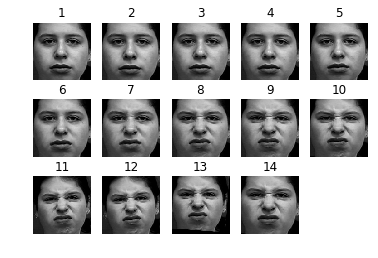

In [16]:
first_sequence = loaded_df.loc[ loaded_df.sequence == loaded_df.iloc[0]['sequence']].sort_values(by='image_number')

i = 0
for imagePath in first_sequence.processed_image_path:  
    image = cv2.imread(imagePath)
    i += 1
    plt.subplot(3, 5, i)
    plt.axis('off')
    plt.title(i)
    plt.imshow(image)
plt.show()